An example: extracting the astrometry of a binary from a swap observation
=========================================================================

Observations
------------

For this example, we are going to use some data obtained during an
observation of HD 25535, on November, 11, 2019. The data are located in
the folder `HD25535/`.

The observation was carried out in *dual-field* (one fiber used for the
Fringe Tracker, FT, and one for the “science” target), *off-axis* (the
roof mirror is used, and neither the FT fiber, not the science fiver, is
centered in the field), using the “swap” template. During a swap
observation, exposures are acquired sequentially with two configurations
(see
Figure <a href="#fig:swap" data-reference-type="ref" data-reference="fig:swap">[fig:swap]</a>):
1- the FT fiber is centered on the target star, and the science fiber is
the requested offset position; 2- the science fiber is one the target
star, and the FT fiber at the given offset position compared to the
science fiber (the two fibers are “swapped”).

Note that this observation pattern can only be used for binary systems
in which the two components are bright enough to feed the FT.

In the present case, a total of 8 exposures were aquired: 2 in the
standard configure (FT on target), 2 in the swapped configuration (FT at
offset position), then again 2 in standard configuration, and 2 in
swapped configuration.

The objective of the data reduction is to extract the astrometry of the
binary. This is done by fitting the visibility of the science object.
But to get a proper astrometry, several problems need to be taken care
of:

1.  We are working with astrored files, so we need to take care of the
    FT zero point, dispersion, and metrology corrections

2.  We are in dual-field, so we need to calculate the phase reference
    and to subtract it to the observed visibilities

3.  We are in swap mode, so keep in mind that half the data are
    measuring $(\Delta\mathrm{RA},\Delta{}\mathrm{DEC})$, and half are
    measuring $(-\Delta\mathrm{RA},-\Delta{}\mathrm{DEC})$

Imports
-------

For this section, we are going to use the `cleanGravity` package, as
well as the plotting functions contained in `gravityPlots` (not
automatically loaded), and a few standard packages. If you want to run
the examples, I suggest you import the following modules:

In [1]:
# useful imports
import numpy as np
import matplotlib.pyplot as plt
import cleanGravity as cg
from cleanGravity import gravityPlot as gplot
import glob

Load the data and apply the corrections
---------------------------------------

### FT corrected visibilities

Using `cleanGravity`, the data can be loaded as
`GravityDualfieldAstrored` objects. You need to specify the path to the
FITS file, and the FITS extension:

In [2]:
# load a file with cleanGravity
oi = cg.GravityDualfieldAstrored("./data/HD25535/GRAVI.2019-11-11T04:18:15.164_astroreduced.fits", extension = 10)

The attribute `oi.visOi` is a `VisOi` object, which contains the
visibility data. The raw data can be accessed in `oi.visOi.visData`. The
package always takes care of correcting for the FT zero point, and the
visibilities referenced to the FT are in `oi.visOi.visRef`. You can
easily visualize the difference between the two using the gravityPlot
functions:

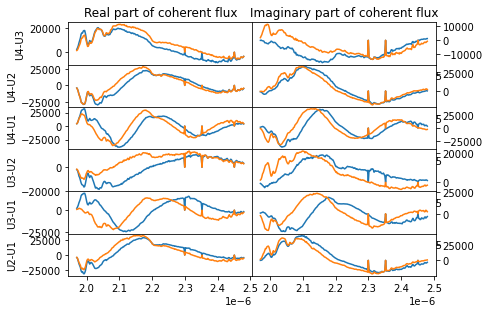

In [3]:
# difference between raw and FT referenced visbilities
fig = plt.figure()
gplot.reImPlot(np.tile(oi.wav, (6, 1)), oi.visOi.visData[0, :, :], subtitles = oi.basenames, fig = fig)
gplot.reImPlot(np.tile(oi.wav, (6, 1)), oi.visOi.visRef[0, :, :], fig = fig)

You can easily see how the FT tracking reference is shifting at each DIT
by plotting the DITs individually:

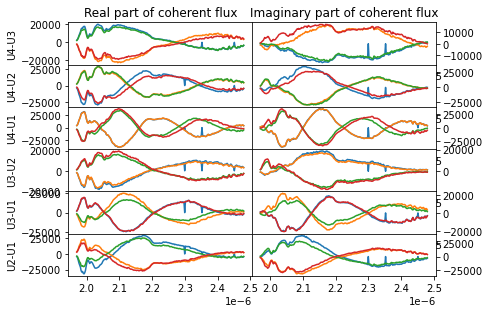

In [4]:
# see how the visData shift with FT reference at each DIT
fig = plt.figure()
gplot.reImPlot(np.tile(oi.wav, (6, 1)), oi.visOi.visData[0, :, :], subtitles = oi.basenames, fig = fig)
for k in range(1, 4):
    gplot.reImPlot(np.tile(oi.wav, (6, 1)), oi.visOi.visData[k, :, :], fig = fig)

Replace `visData` with `visRef`, and you should see that the FT
corrected visibilities are now better aligned:

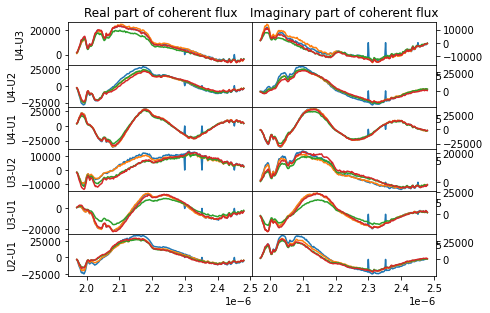

In [5]:
# visRef is much more stable
fig = plt.figure()
gplot.reImPlot(np.tile(oi.wav, (6, 1)), oi.visOi.visRef[0, :, :], subtitles = oi.basenames, fig = fig)
for k in range(1, 4):
    gplot.reImPlot(np.tile(oi.wav, (6, 1)), oi.visOi.visRef[k, :, :], fig = fig)

### OPD dispersion correction

When working with fully reduced data (“scivis” files), this step is
taken care of by the GRAVITY pipeline. But when working with the
“astrored” data, this correction is not applied by the pipeline.
However, the OPD that needs to be added to the visibilities is
calculated by the pipeline, and is available in `oi.visOi.opdDisp`. So
the correction is a simple one-liner:

In [6]:
# correct for OPD dispersion
oi.visOi.visRef = oi.visOi.visRef * np.exp(-1j*2*np.pi*oi.visOi.opdDisp/oi.visOi.wav)

Note that, in order to properly propagate the covariance and
pseudo-covariance matrices, the use of the `visOi.addPhase` method
should be prefered (see previous section)

For convenienence, this correction can also be applied directly when
loading the data with `cleanGravity`, simply by setting a `corrDisp`
keyword to `"drs"` instead of the default `"none"`:

In [7]:
# OPD correction when loading the file
oi = cg.GravityDualfieldAstrored("./data/HD25535/GRAVI.2019-11-11T04:18:15.164_astroreduced.fits", extension = 10, corrDisp = "drs")

### Metrology correction

The metrology correction is also done by the pipeline on the “scivis”
file, but not on the “astrored” files. Since we are working with the
latter, we need to apply it manually. Again, this can be done by setting
a keyword `corrMet = "drs"` when loading the data:

In [8]:
# metrology correction when loading the file
oi = cg.GravityDualfieldAstrored("./data/HD25535/GRAVI.2019-11-11T04:18:15.164_astroreduced.fits", extension = 10, corrDisp = "drs", corrMet = "drs")

But for the sake of explanations, we are going to do it manually. The
metrology correction comes from telescope-based measurements. This means
that the required quantities must be retrieved from the flux OI, not
from the visibility OI. They are available in the `oi.fluxOi` object, as
`oi.visOi.telFcCorr` and `oi.visOi.fcCorr`. The sum of the two give an
OPD correction for each telescope. To convert it to a correction for
each baseline, it is necessary to calculate the difference between the
proper telescopes (two telescope per baseline).

In the `visOi` object, the visibilities are ordered in decreasing order:
$T_4$-$T_3$, $T_4$-$T_2$, $T_4$-$T_1$, $T_3$-$T_2$, $T_3$-$T_1$,
$T_2$-$T_1$. The same if true for the telescopes in the `fluxOi`: $T_4$,
$T_3$, $T_2$, $T_1$. Thus, the conversion from telescope-based errors to
baseline-based errors can be done using the following matrix:

In [9]:
# matrix to link telescopes and baselines
telCorrToBaseCorr = np.array([[1, -1, 0, 0],
                               [1, 0, -1, 0],
                               [1, 0, 0, -1],
                               [0, 1, -1, 0],
                               [0, 1, 0, -1],
                               [0, 0, 1, -1]])

With the matrix, the correction proceeds easily. You just have to remind
that the values give an OPD correction, which needs to be divided by
$\lambda$ to get a phase correction:

In [10]:
# manual metrology correction
phaseCorr = 2*np.pi/oi.wav*(np.dot(telCorrToBaseCorr, (oi.fluxOi.telFcCorr + oi.fluxOi.fcCorr).T).T[:, :, None])
oi.visOi.visRef = oi.visOi.visRef*np.exp(-1j*phaseCorr)

Again, the `visOi.addPhase` should be used here, to propagate the error
matrices properly.

Optional: calculate the mean of the DITs
----------------------------------------

This step is optional. It is usually better to keep the DITs separated,
but depending on how many files you have to reduce, and what the
spectral resolution is, the computation can then be lengthy. Thus, when
testing, it can be useful to average the DITs to speed up things.

Due to the rotation of the sky, averaging the visibilities is not as
trivial as it sounds. The OPD on each baseline is changing with time,
and thus the phase of the visibility is drifting. As a consequence, to
average the visibilities properly, you first need to “shift” them to
$\mathrm{OPD} = 0$. Ideally, this should be done using the proper
astrometry of the target. Since it is unknown, the best way is to
proceed using the position of the fiber as a substitute. To do that, you
can use the `recenterPhase` method of the `visOi` object, to “recenter”
the visbilities on the fiber position (available in RA/DEC in `oi.sObjX`
and `oi.sObjY`). Then you can average the visibilities, the baselines UV
coordinates, and shift the visibilities back to their original position:

In [11]:
# average the visbilities over the DITs
oi = cg.GravityDualfieldAstrored("./data/HD25535/GRAVI.2019-11-11T04:26:33.186_astroreduced.fits", extension = 10, corrMet = "drs", corrDisp = "drs")
oi.visOi.recenterPhase(oi.sObjX, oi.sObjY) # shift to 0 OPD (or close)
oi.visOi.visData = np.tile(np.copy(oi.visOi.visData).mean(axis = 0), (1, 1, 1))
oi.visOi.visRef = np.tile(np.copy(oi.visOi.visRef).mean(axis = 0), (1, 1, 1))
oi.visOi.uCoord = np.tile(np.copy(oi.visOi.uCoord).mean(axis = 0), (1, 1, 1))
oi.visOi.vCoord = np.tile(np.copy(oi.visOi.vCoord).mean(axis = 0), (1, 1, 1))
oi.visOi.u = np.tile(np.mean(oi.visOi.u, axis = 0), (1, 1))
oi.visOi.v = np.tile(np.mean(oi.visOi.v, axis = 0), (1, 1))
oi.visOi.ndit = 1
oi.ndit = 1
oi.visOi.recenterPhase(-oi.sObjX, -oi.sObjY) # back to FT reference position

When calculating the mean in this way, the covariance and
pseudo-covariance matrices also need to be propagated:

In [12]:
# propagate the error matrices
oi.visOi.recenterPhase(oi.sObjX, oi.sObjY) # shift back to 0 OPD (or close)
for c in range(oi.visOi.nchannel):
    oi.visOi.visRefCov[0, c] = np.sum(oi.visOi.visRefCov[:, c]) # for each channel we sum over dits
    oi.visOi.visRefPcov[0, c] = np.sum(oi.visOi.visRefPcov[:, c])
    oi.visOi.visRefCov = oi.visOi.visRefCov[0:1, :]/oi.visOi.ndit**2 # keep only the average
    oi.visOi.visRefPcov = oi.visOi.visRefPcov[0:1, :]/oi.visOi.ndit**2
oi.visOi.recenterPhase(-oi.sObjX, -oi.sObjY) # back to original frame again

Note that in the above code, the use of the `np.tile` functions
guarantees that the visibility data keep the same format (3 dimensional
arrays, first dimension for the DIT number, second for the channel, and
third for the walength).

The `cleanGravity` also provides a function to average the visibility
and propagate the covariance matrices automatically:

In [13]:
# average the visbilities over the DITs using cleanGravity
oi = cg.GravityDualfieldAstrored("./data/HD25535/GRAVI.2019-11-11T04:26:33.186_astroreduced.fits", extension = 10, corrMet = "drs", corrDisp = "drs")
oi.visOi.recenterPhase(oi.sObjX, oi.sObjY) # shift to 0 OPD (or close)
oi.visOi.computeMean()
oi.visOi.recenterPhase(-oi.sObjX, -oi.sObjY) # shift back to original frame

Separate and average the swap positions and calculate the phase reference
-------------------------------------------------------------------------

At this point, you have the visibilities referenced to the FT, properly
corrected for the dispersion, and for the metrology (i.e. for non
common-path errors). Potentially, you have also averaged those
visibilities. But these visibilities are still corrupted by the unknown
metrology zero point (i.e. the phase picked up at the injection of the
metrology laser in the system). Fortunately, this phase error is
extremely stable. This means that, as long as you did not switched the
observing mode (on-axis/off-axis) between the different exposures, this
phase offset will be the same in all the data.

Consequently, for a swap observation, the phase at the two positions are
respectively given by: $$\begin{aligned}
\text{Before the swap:} \qquad & \phi(u, v) = \frac{2\pi}{\lambda}\left(\Delta\mathrm{RA}\times{}u+\Delta\mathrm{DEC}\times{}v\right) + \phi_\mathrm{ref} \\
\text{After the swap:}  \qquad & \phi_\mathrm{swap}(u, v) = \frac{2\pi}{\lambda}\left(-\Delta\mathrm{RA}\times{}u-\Delta\mathrm{DEC}\times{}v\right) + \phi_\mathrm{ref}  \end{aligned}$$

Calculating the phase reference is thus just a matter of summing the
phase of the two positions:
$$\phi_\mathrm{ref} = \frac{\phi + \phi_\mathrm{swap}}{2}$$

So the sequence to retrieve the phase reference is the following:

1.  Load all the files, and correct the visibilities referenced to the
    FT for dispersion and metrology

2.  Separate the OIs in two groups: standard and swapped. This can be
    done using the `oi.swap` boolean

3.  Average the visibilities over each of the two groups, and extract
    the phase[1]

4.  Calculate the phase reference

5.  Subtract this phase reference to the visibilities of each file

In Python, this goes as follows. First, all files are loaded and
separated in two groups with:

[1] The instrument measures the real and imaginary parts of the
visibilities, not the phase. So you should always average the
visibilities first and calculate the phase after! Never do the opposite
(calculate the phase and then average).

In [14]:
# load the files, and separate in two groups for 2 swap positions
datafiles = glob.glob("./data/HD25535/*.fits")
datafiles.sort()
oi_stand, oi_swap = [], []
for filename in datafiles:
    oi = cg.GravityDualfieldAstrored(filename, extension = 10, corrDisp = "drs", corrMet = "drs")
    if oi.swap:
        oi_swap.append(oi)
    else:
        oi_stand.append(oi)

Then, the average on each group can be calculated, again by first
shifting the visibilities to 0 OPD:

In [15]:
# average each group properly
visStand = np.zeros([oi.visOi.nchannel, oi.visOi.nwav])
visSwap = np.zeros([oi.visOi.nchannel, oi.visOi.nwav])
for oi in oi_stand:
    oi.visOi.recenterPhase(oi.sObjX, oi.sObjY)
    visStand = visStand+oi.visOi.visRef.mean(axis = 0)/len(oi_stand)
    oi.visOi.recenterPhase(-oi.sObjX, -oi.sObjY)    
for oi in oi_swap:
    oi.visOi.recenterPhase(oi.sObjX, oi.sObjY)
    visSwap = visSwap+oi.visOi.visRef.mean(axis = 0)/len(oi_swap)
    oi.visOi.recenterPhase(-oi.sObjX, -oi.sObjY)

The phase reference is extracted and removed from all the OIs:

In [16]:
# get the phase reference and remove it from each OI
phaseRef = 0.5*(np.angle(visStand)+np.angle(visSwap))
for oi in oi_stand+oi_swap:
    oi.visOi.addPhase(-phaseRef)

Fit for the astrometry
----------------------

From there on, the visibility you have in `oi.visOi.visRef` should
correspond to the astrophysical visibilities. The last thing to do is to
fit for the astrometry of the binary.

A simple model for the visibilities, with two free parameters
$\Delta\mathrm{RA}$ and $\Delta\mathrm{DEC}$ can be built from the
following equation, which gives the visibility as a function of the
baseline coordinates:
$$V_{(\Delta{}\mathrm{RA}, \Delta{}\mathrm{DEC})}(U, V) = |V|\exp\left\{{i\,2\pi}\left(\Delta\mathrm{RA}\times{}U+\Delta\mathrm{DEC}\times{}V\right)\right\}$$
In which $|V|$ is a visibility modulus.

A basic fit of this model could be a linear fit, in which a scaling
factor is adjusted for each baseline and each DIT, to take into account
the variations in the transmission. It should be noted, though, that you
should never let the scaling factor be negative. A negative scaling
factor can “revert” the fringes, making a completely out-of-phase model
(i.e. with a phase offset of $\pi$ compared to the data) look “good”.
One simple strategy is to operate a linear fit, and if the resulting
scaling coefficient is negative, set it to 0. Alternatively, if the
model include other elements, for example an underlying polynomial to
model a contamination on the detector, you could set the wavelet (the
visibility model) to 0, and redo the fit only with the polynomial.

The corresponding code would be something along this line:

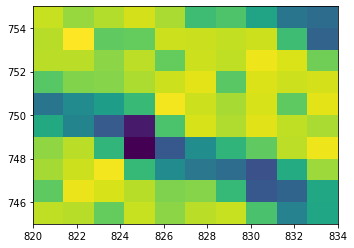

In [17]:
# chi2 map to extract the astrometry
oi = oi_stand[0] # we fit only the first oi in this example
raValues = np.linspace(820, 834, 10) # the ra grid
decValues = np.linspace(745, 755, 10) # the dec grid
chi2Map = np.zeros([oi.visOi.ndit, len(raValues), len(decValues)]) # one map for each dit
Y, X = np.zeros([1, 2*oi.nwav]), np.zeros([1, 2*oi.nwav]) # Y will contain data, X will contain model
for m in range(len(raValues)):
    for n in range(len(decValues)): # loop through grid
        ra, dec = raValues[m]/1000.0/3600.0/180.0*np.pi, decValues[n]/1000.0/3600.0/180.0*np.pi # convert to rad
        wavelet = np.exp(-1j*2*np.pi*(ra*oi.visOi.uCoord+dec*oi.visOi.vCoord)) # the visibility model, without the amplitude
        for dit in range(oi.visOi.ndit):
            for c in range(oi.visOi.nchannel): 
                # here we need to explicitly separate the real/imag parts and do the fitting for the
                # scaling coefficient in real numbers. Otherwise we would get a complex coeff, which
                # means it would also be fitting for the phase offset. 
                X[0, 0:oi.nwav] = np.real(wavelet[dit, c, :]) # model
                X[0, oi.nwav:] = np.imag(wavelet[dit, c, :]) # model               
                Y[0, 0:oi.nwav] = np.real(oi.visOi.visRef[dit, c, :]) # data 
                Y[0, oi.nwav:] = np.imag(oi.visOi.visRef[dit, c, :]) # data
                coeff = np.dot(Y, np.linalg.pinv(X)) # linear fit
                if coeff[0, 0] < 0: # if coeff is negative, set model to 0 and redo the fit
                    coeff[0, 0] = 0
                    X[0, :] = 0
                    coeff = np.dot(Y, np.linalg.pinv(X))
                Yfit = np.dot(coeff, X)
                chi2Map[dit, m, n] = chi2Map[dit, m, n]+np.sum((Y-Yfit)**2) # sum of squared differences
# show the map
plt.figure()
plt.imshow(np.sum(chi2Map, axis = 0).T, origin="lower", extent = [np.min(raValues), np.max(raValues), np.min(decValues), np.max(decValues)])

Of course, this is valid for the standard position. For the swapped
position, the measured astrometry is the opposite of the true astrometry
of the binary:
$$V^{\mathrm{swap}}_{(\Delta{}\mathrm{RA}, \Delta{}\mathrm{DEC})}(U, V) = |V|\exp\left\{{-i\,2\pi}\left(\Delta\mathrm{RA}\times{}U+\Delta\mathrm{DEC}\times{}V\right)\right\}$$

From this, you can calculate a $\chi^2$ map for each OI, and extract the
correponding best astrometry, with its error bars. You have reduced a
GRAVITY dual-field and off-axis data set!

This example is pretty much what is contained in the `swapReduce.py`
script of the `exoGravity` package.

Optional: OPD-based calculation of the $\chi^2$ map
---------------------------------------------------

There is another way to calculate the astrometry $\chi^2$ maps, which is
used in the exoGravity pipeline, because it goes faster and provides
similar results.

The basic idea is that, for each baseline, the RA and DEC values are
combined as a sum, virtually acting as a single parameter. This means
that what we are really trying to fit in the data is the OPD at each
baseline. Thus, you cal calculate $\chi^2$ maps in OPD (one per baseline
and per file), simply by fiting a single parameter model like:
$$V_{\mathrm{OPD}}(U, V) = |V|\exp\left\{i\,\frac{2\pi}{\lambda}\mathrm{OPD}\right\}$$

The $(\Delta\mathrm{RA}, \Delta\mathrm{DEC})$, can then be calculated
from these OPD maps by simple summation, i.e. for each
$\Delta\mathrm{RA}, \Delta\mathrm{DEC}$ values, and each baseline
$(u, v)$, you can calculate the corresponding OPD:
$$\mathrm{OPD}_{\Delta\mathrm{RA}, \Delta\mathrm{DEC}}(u, v) = \Delta\mathrm{RA}\times{}u+\Delta\mathrm{DEC}\times{}v$$

And then sum:
$$\chi^2(\Delta{}\mathrm{RA}, \Delta{}\mathrm{DEC}) = \sum_{u, v} \chi^2\left(\mathrm{OPD}_{\Delta\mathrm{RA}, \Delta\mathrm{DEC}}(u, v)\right)$$

The corresponding code is left as an exercice to the reader.

Calculating the astrometry using cleanGravity methods
-----------------------------------------------------

The calculation presented in the previous two sections is sub-optimal,
as the error matrices are not taken into account. It is possible to
improve the model to take into account the errors. A proper
noise-weighted likelihood maximizationprocedure is already impleneted in
`visOi`, which can be used to calculate the astrometric $\chi^2$ maps.

The model implemented is a model which is linear at fixed
$\Delta{}\mathrm{RA}, \Delta{}\mathrm{DEC}$, and which can include:

-   a target spectrum $S(\lambda)$ which only depends on the wavelength

-   a background polynomial of order $p$ in $\lambda$, with complex
    coefficients (different for each baseline) and possibly multiplied
    by a spectrum which can also depend on the baseline: $R(b, \lambda)$

The corresponding equation can be written:
$$V(b, \lambda) = c\times{}S(\lambda)\exp\left\{i\,2\pi\left(\Delta\mathrm{RA}\times{}U+\Delta\mathrm{DEC}\times{}V\right)\right\}+R(b, \lambda)\sum_{k=0}^{p}a_k(b)\lambda^k$$
where $p$, $R$, $S$ are fixed quantities provided by the user, the $a_k$
coefficients and $c$ are optimized at each step in $\Delta\mathrm{RA}$
and $\Delta\mathrm{DEC}$.

In practice, instead of working directly in $\Delta\mathrm{RA}$ and
$\Delta\mathrm{DEC}$, the code contained in `cleanGravity` starts by
calculating the model in OPD space (replacing the exponential term by
$e^{i\frac{2\pi\mathrm{OPD}}{\lambda}}$), and then interpolates it to
create a $\chi^2$ map in sky-coordinates.

Best astrometry: RA=824.6666666666666 mas, RA=748.3333333333334 mas


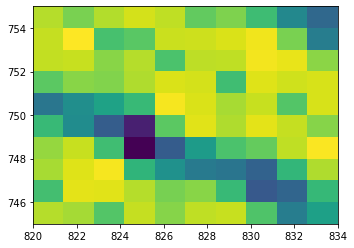

In [20]:
# calculate the map using cleanGravity methods
astrometryFit = oi.visOi.fitVisRefAstrometry(raValues, decValues, nopd=100, poly_order=0, target_spectrum=None, poly_spectrum=None)
chi2Map = astrometryFit["map"]
solution = astrometryFit["best"]
print("Best astrometry: RA={} mas, RA={} mas".format(solution[0], solution[1]))
plt.figure()
plt.imshow(chi2Map.sum(axis=0).T, origin="lower", extent = [np.min(raValues), np.max(raValues), np.min(decValues), np.max(decValues)])